### Installing dependencies

In [1]:
!pip install diffusers
!pip install transformers
!pip install accelerate>=0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


### Import the dependencies

In [2]:
from diffusers.utils import load_image, make_image_grid
from diffusers import ControlNetModel, AutoPipelineForImage2Image
import torch
import torch.optim as optim

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### Data Preprocessing


In [3]:
%cd /content/drive/MyDrive/ADL_proj

/content/drive/MyDrive/ADL_proj


In [ ]:
!ls datasets/test_2k_pre_calc_sgm_flows/Disney_v4_22_003578_s2/

guide_flo13.jpg  guide_flo31.jpg  matching_color_1to3.jpg
guide_flo13.npy  guide_flo31.npy  matching_color_3to1.jpg


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class VideoFrameDataset(Dataset):
    def __init__(self, main_dir, flow_dir, transform=None):
        """
        Args:
            main_dir (string): Directory with all the images folders (datasets/test_2k_540p).
            flow_dir (string): Directory with all the optical flow images (datasets/test_2k_pre_calc_sgm_flows).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.main_dir = main_dir
        self.flow_dir = flow_dir
        self.transform = transform

        # List all the subdirectories in the main directory
        self.folders = [f for f in os.listdir(main_dir)[:100] if os.path.isdir(os.path.join(main_dir, f))]

        # Sort folders to maintain order
        self.folders.sort()

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_name = self.folders[idx]

        # Paths to the specific images and flow file
        frame1_path = os.path.join(self.main_dir, folder_name, "frame1.png")
        frame3_path = os.path.join(self.main_dir, folder_name, "frame3.png")

        flow_path_png = os.path.join(self.flow_dir, folder_name, "guide_flo13.png")
        flow_path_jpg = os.path.join(self.flow_dir, folder_name, "guide_flo13.jpg")
        if os.path.exists(flow_path_png):
            flow_path = flow_path_png
        elif os.path.exists(flow_path_jpg):
            flow_path = flow_path_jpg
        else:
            raise FileNotFoundError(f"No optical flow image found in PNG or JPG format for folder {folder_name}")

        # Load images
        frame1 = Image.open(frame1_path).convert("RGB")
        frame3 = Image.open(frame3_path).convert("RGB")
        flow = Image.open(flow_path).convert("RGB")

        if self.transform:
            frame1 = self.transform(frame1)
            frame3 = self.transform(frame3)
            flow = self.transform(flow)

        # frame1 and flow are the inputs; frame3 is the target
        return (frame1, flow), frame3

# Example of a transform
transform = transforms.Compose([
    transforms.Resize((540, 960)),  # Resize to match your needs
    transforms.ToTensor(),
])

# Usage
main_dir = "datasets/test_2k_540p"
flow_dir = "datasets/test_2k_pre_calc_sgm_flows"
dataset = VideoFrameDataset(main_dir=main_dir, flow_dir=flow_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [50]:
import os
from PIL import Image
import datasets
import base64
from io import BytesIO

def encode_image(image):
    """Encode an image to base64."""
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

def create_hf_dataset(main_dir, flow_dir):
    temp = {'image': [], 'flow': [], 'target': [], 'text': []}

    folders = [f for f in os.listdir(main_dir)[:10] if os.path.isdir(os.path.join(main_dir, f))]
    folders.sort()

    for folder in folders:
        frame1_path = os.path.join(main_dir, folder, "frame1.png")
        frame3_path = os.path.join(main_dir, folder, "frame3.png")
        flow_path_png = os.path.join(flow_dir, folder, "guide_flo13.png")
        flow_path_jpg = os.path.join(flow_dir, folder, "guide_flo13.jpg")

        if os.path.exists(flow_path_png):
            flow_path = flow_path_png
        elif os.path.exists(flow_path_jpg):
            flow_path = flow_path_jpg
        else:
            continue  # or handle missing file

        # Load and encode images
        frame1 = Image.open(frame1_path).convert("RGB")
        frame3 = Image.open(frame3_path).convert("RGB")
        flow = Image.open(flow_path).convert("RGB")

        temp['image'].append(frame1)
        temp['flow'].append(flow)
        temp['target'].append(frame3)
        temp['text'].append("Placeholder text for image")

    # Create a Dataset object directly from temp
    train_dataset = datasets.Dataset.from_dict(temp)

    # Create a DatasetDict with a 'train' split
    dataset_dict = datasets.DatasetDict({
        'train': train_dataset
    })

    return dataset_dict

# Paths to your data
main_dir = "/content/drive/MyDrive/ADL_proj/datasets/test_2k_540p"
flow_dir = "/content/drive/MyDrive/ADL_proj/datasets/test_2k_pre_calc_sgm_flows"

# Create dataset
hf_dataset = create_hf_dataset(main_dir, flow_dir)


In [51]:
!rm -rf /content/drive/MyDrive/ADL_proj/hf_data

In [52]:
hf_dataset.save_to_disk("/content/drive/MyDrive/ADL_proj/hf_data")

Saving the dataset (0/1 shards):   0%|          | 0/10 [00:00<?, ? examples/s]

### Check results on one image

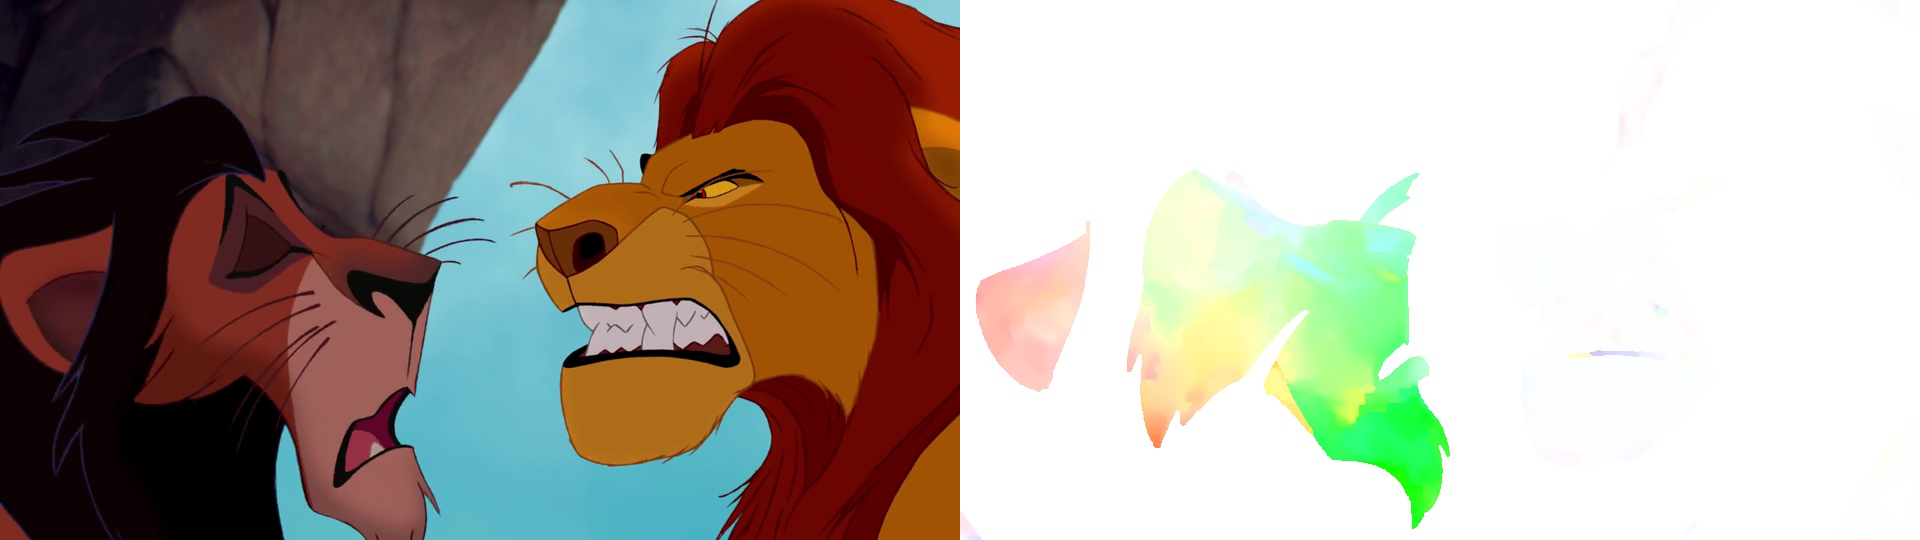

In [4]:
# prepare image
url = "datasets/test_2k_540p/Disney_v4_0_001509_s1/frame1.png"
init_image = load_image(url)
init_image = init_image.resize((960, 540)) # resize to depth image dimensions
depth_image = load_image("datasets/test_2k_pre_calc_sgm_flows/Disney_v4_0_001509_s1/guide_flo31.jpg")
make_image_grid([init_image, depth_image], rows=1, cols=2)

In [5]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16, variant="fp16", use_safetensors=True)
pipeline = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
# pipeline.enable_xformers_memory_efficient_attention()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/945 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/723M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
init_image.size, depth_image.size

((960, 540), (960, 540))

  0%|          | 0/40 [00:00<?, ?it/s]

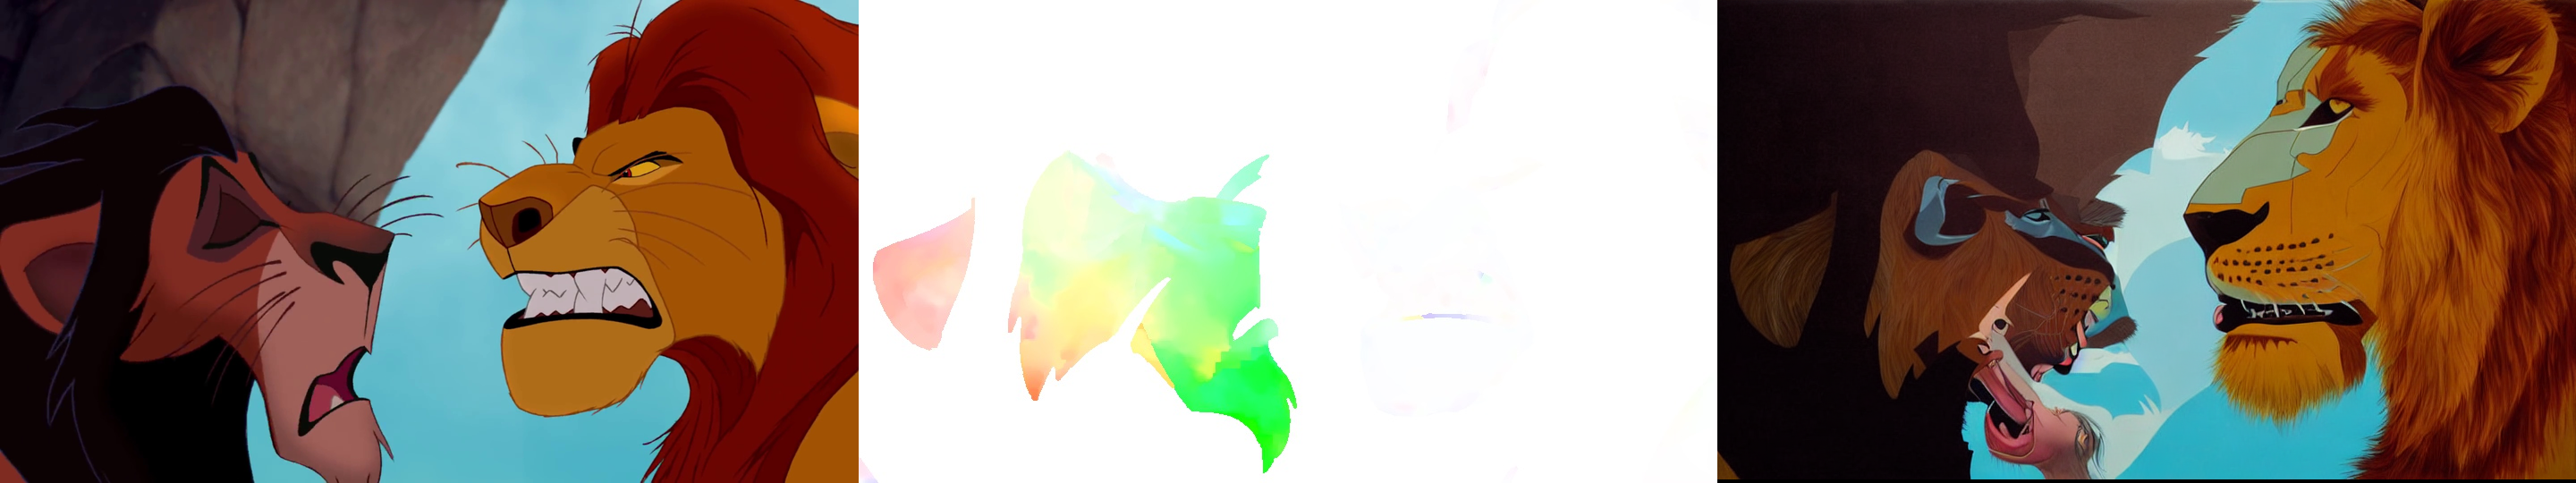

In [12]:
prompt = "two lions in New york"
image_control_net = pipeline(prompt, image=init_image, control_image=depth_image).images[0]
make_image_grid([init_image, depth_image, image_control_net], rows=1, cols=3)

### Fine-tuning


In [1]:
!git clone https://github.com/huggingface/diffusers

Cloning into 'diffusers'...
remote: Enumerating objects: 60818, done.
remote: Counting objects: 100% (817/817), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 60818 (delta 498), reused 505 (delta 288), pack-reused 60001
Receiving objects: 100% (60818/60818), 42.16 MiB | 12.63 MiB/s, done.
Resolving deltas: 100% (44193/44193), done.


In [2]:
%cd diffusers

/content/diffusers


In [3]:
!pip install .

Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.28.0.dev0-py3-none-any.whl size=2094346 sha256=7744cac570e6a265a4f7a124156e477d6601181a6f04d4d74cca5256377798c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-_9kfbfpe/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers


In [4]:
%cd examples/controlnet/

/content/diffusers/examples/controlnet


In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [6]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [7]:
!pwd

/content/diffusers/examples/controlnet


In [15]:
!export MODEL_DIR="runwayml/stable-diffusion-v1-5"
!export OUTPUT_DIR="/content/drive/MyDrive/ADL_proj/outputs"

In [53]:
!accelerate launch train_controlnet.py \
 --pretrained_model_name_or_path=$MODEL_DIR \
 --output_dir=$OUTPUT_DIR \
 --dataset_name=/content/drive/MyDrive/ADL_proj/hf_data \
 --resolution=512 \
 --learning_rate=1e-5 \
  --conditioning_image_column=flow \
 --image_column=target \
 --caption_column=None \
 --validation_image "datasets/test_2k_pre_calc_sgm_flows/Disney_v4_0_001509_s1/guide_flo31.jpg" \
 --validation_prompt "lion growling and lion tired" \
 --train_batch_size=4 \
 --gradient_accumulation_steps=4 \

Traceback (most recent call last):
  File "/usr/local/bin/accelerate", line 5, in <module>
    from accelerate.commands.accelerate_cli import main
  File "/usr/local/lib/python3.10/dist-packages/accelerate/__init__.py", line 16, in <module>
    from .accelerator import Accelerator
  File "/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py", line 35, in <module>
    from .checkpointing import load_accelerator_state, load_custom_state, save_accelerator_state, save_custom_state
  File "/usr/local/lib/python3.10/dist-packages/accelerate/checkpointing.py", line 24, in <module>
    from .utils import (
  File "/usr/local/lib/python3.10/dist-packages/accelerate/utils/__init__.py", line 29, in <module>
  File "/usr/local/lib/python3.10/dist-packages/accelerate/utils/dataclasses.py", line 35, in <module>
    from .imports import is_cuda_available, is_npu_available, is_xpu_available
  File "/usr/local/lib/python3.10/dist-packages/accelerate/utils/imports.py", line 16, in <module>


In [57]:
!python train_controlnet.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --output_dir="/content/drive/MyDrive/ADL_proj/outputs" \
  --dataset_name="/content/drive/MyDrive/ADL_proj/hf_data" \
    --conditioning_image_column=flow \
 --image_column=target \
 --caption_column=text \
 --num_train_epochs=5 \
  --train_batch_size=1 \
  --learning_rate=1e-5

2024-04-26 03:17:29.192108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 03:17:29.192155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 03:17:29.193629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 03:17:30.801532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
04/26/2024 03:17:31 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type

In [63]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
import torch

controlnet = ControlNetModel.from_pretrained("/content/drive/MyDrive/ADL_proj/outputs/", torch_dtype=torch.float16)
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [67]:
control_image = load_image( "/content/drive/MyDrive/ADL_proj/datasets/test_2k_540p/Disney_v4_0_001509_s1/frame1.png")
prompt = "new york city pizza"

generator = torch.manual_seed(0)
image = pipeline(prompt, num_inference_steps=20, generator=generator, image=control_image).images[0]
image.save("/content/drive/MyDrive/ADL_proj/output.png")

  0%|          | 0/20 [00:00<?, ?it/s]